In [92]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from scipy.stats import qmc 
import matplotlib.pyplot as plt
from matplotlib import cm 

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cuda:0


In [93]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 100
number_of_bc1_points = 50
number_of_bc2_points = 50
# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #1차원 샘플을 만들어줄 엔진(인스턴스)생성

# temporal data points
t_d_b = engine.random(n=number_of_bc1_points + number_of_bc2_points)
t_d_b = (np.pi/2)*t_d_b
t_d_o = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
# spatial data points
x_d_o = engine.random(n=number_of_ic_points)
x_d_o = 10*(x_d_o-0.5)
temp1 = 5* np.ones([number_of_bc1_points, 1]) # for BC1 ; x = 5
temp2 = (-5)*np.ones([number_of_bc2_points, 1]) # for BC2 ; x = -5
x_d_b = np.append(temp1, temp2, axis=0)

#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

In [94]:


# for initial condition:


y_d_ou = 2*np.reciprocal(np.cosh(x_d_o))
y_d_ov = np.zeros([number_of_ic_points,1])
y_d_o = np.append(y_d_ou,y_d_ov,axis=1)



# number of collocation points
Nc = 20000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
data[:, 1] = 10*(data[:, 1]-0.5)
data[:, 0] = (np.pi/2)*(data[:, 0])

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)
     

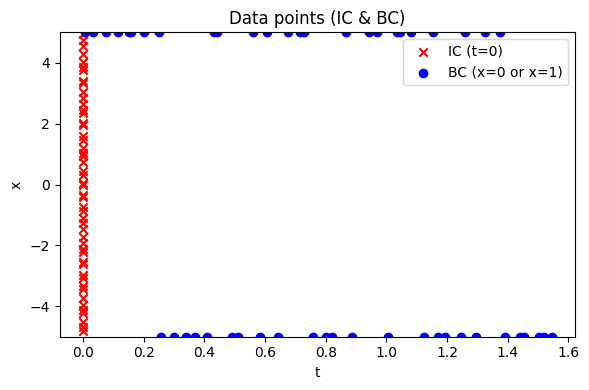

In [95]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))

# IC: 빨간색 x 마커
plt.scatter(t_d_o, x_d_o, marker="x", c="r", label="IC (t=0)")

# BC: 파란색 o 마커
plt.scatter(t_d_b, x_d_b, marker="o", c="b", label="BC (x=0 or x=1)")

plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (IC & BC)")
plt.legend()

# x 범위가 0~1이면 아래처럼
plt.ylim(-5, 5)

plt.tight_layout()
plt.show()


In [96]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(2,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.hidden_layer3 = nn.Linear(20,20)
        self.hidden_layer4 = nn.Linear(20,20)
        self.hidden_layer5 = nn.Linear(20,20)
        self.hidden_layer6 = nn.Linear(20,20)
        self.hidden_layer7 = nn.Linear(20,20)
        self.hidden_layer8 = nn.Linear(20,20)
        self.hidden_layer9 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,2)
        
    def forward(self,x,t) :
        inputs = torch.cat([x,t],axis =1 )
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        layer6_out = torch.tanh(self.hidden_layer6(layer5_out))
        layer7_out = torch.tanh(self.hidden_layer7(layer6_out))
        layer8_out = torch.tanh(self.hidden_layer8(layer7_out))
        layer9_out = torch.tanh(self.hidden_layer9(layer8_out))
        output = self.output_layer(layer9_out) 
        return output
    
    
"""
probably the quesion part is activation function. how about tanh??? or sin?
"""

'\nprobably the quesion part is activation function. how about tanh??? or sin?\n'

In [97]:
net = Net() # is what we defined and stands for net.
net = net.to(device) #is to send net calculation to device
mse_cos_function = torch.nn.MSELoss() #is mean squared error loss function
optimizer = torch.optim.Adam(net.parameters()) # is for optimizer name Adam for parameters in our model.


In [98]:
def f(x, t, net):
    h = net(x, t)  # h: (batch_size, 2)
    u = h[:, 0:1]  # (batch_size, 1)
    v = h[:, 1:2]  # (batch_size, 1)
    
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    # 거듭제곱은 ** 연산자로!
    res_1 = -v_t + 0.5*u_xx + (u**2 + v**2)*u
    res_2 =  u_t + 0.5*v_xx + (u**2 + v**2)*v

    # np.append 대신 torch.cat을 사용해 (batch_size, 2) 텐서로 합친다
    residual = torch.cat([res_1, res_2], dim=1)

    return residual


In [99]:
def h_x(x, t, net):
    h = net(x, t)  # h.shape -> (batch_size, 2)
    
    # h[:, 0:1] -> (batch_size, 1), h[:, 1:2] -> (batch_size, 1)
    u = h[:, 0:1]
    v = h[:, 1:2]
    
    # u_x, v_x -> (batch_size, 1)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    
    # h_x도 (batch_size, 2) 형태
    # np.append 대신 torch.cat을 사용
    h_x = torch.cat([u_x, v_x], dim=1)
    
    return h_x


In [102]:
iterations = 5000
previous_validation_loss=99999999.0

for epoch in range(iterations) :
    optimizer.zero_grad()
    
    #loss based on bc
    
    pt_x_d_o = Variable(torch.from_numpy(x_d_o).float(),requires_grad=False).to(device)
    pt_t_d_o= Variable(torch.from_numpy(t_d_o).float(),requires_grad=False).to(device) 
    pt_x_d_b = Variable(torch.from_numpy(x_d_b).float(),requires_grad=True).to(device)
    pt_t_d_b = Variable(torch.from_numpy(t_d_b).float(),requires_grad=False).to(device)
    pt_y_d_o = Variable(torch.from_numpy(y_d_o).float(),requires_grad=False).to(device)


    
    net_bc_out5 = net(pt_x_d_b[:number_of_bc1_points,:],pt_t_d_b[:number_of_bc1_points,:])
    net_bc_outm5 = net(pt_x_d_b[number_of_bc1_points:,:],pt_t_d_b[number_of_bc1_points:,:])
    net_bc2_out5 = h_x(pt_x_d_b[:number_of_bc1_points,:],pt_t_d_b[:number_of_bc1_points,:],net)
    net_bc2_outm5 = h_x(pt_x_d_b[number_of_bc1_points:,:],pt_t_d_b[number_of_bc1_points:,:],net)
    net_ic_out = net(pt_x_d_o,pt_t_d_o)
    mse_0 = mse_cos_function(net_ic_out,pt_y_d_o)
    net_ic_out1 = net(pt_x_d_o,pt_t_d_o)
    mse_b1= mse_cos_function(net_bc_out5,net_bc_outm5)
    mse_b2= mse_cos_function(net_bc2_out5,net_bc2_outm5)
    mse_b=mse_b1+mse_b2
    
    
    
    
    #loss based on PDE
    
 
    all_zeros = np.zeros((Nc,1))
    
    pt_x_c = Variable(torch.from_numpy(x_c).float(),requires_grad=True).to(device)
    pt_t_c = Variable(torch.from_numpy(t_c).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_c,pt_t_c,net)
    mse_f = mse_cos_function(f_out,pt_all_zeros)
    
    loss = mse_0+mse_b+ mse_f
    
    loss.backward()
    
    optimizer.step()
    
    with torch.autograd.no_grad():
        print(epoch,"training loss",loss.data)

0 training loss tensor(0.0158, device='cuda:0')
1 training loss tensor(0.0150, device='cuda:0')
2 training loss tensor(0.0135, device='cuda:0')
3 training loss tensor(0.0130, device='cuda:0')
4 training loss tensor(0.0137, device='cuda:0')
5 training loss tensor(0.0142, device='cuda:0')
6 training loss tensor(0.0140, device='cuda:0')
7 training loss tensor(0.0139, device='cuda:0')
8 training loss tensor(0.0138, device='cuda:0')
9 training loss tensor(0.0134, device='cuda:0')
10 training loss tensor(0.0129, device='cuda:0')
11 training loss tensor(0.0130, device='cuda:0')
12 training loss tensor(0.0135, device='cuda:0')
13 training loss tensor(0.0136, device='cuda:0')
14 training loss tensor(0.0133, device='cuda:0')
15 training loss tensor(0.0131, device='cuda:0')
16 training loss tensor(0.0131, device='cuda:0')
17 training loss tensor(0.0130, device='cuda:0')
18 training loss tensor(0.0129, device='cuda:0')
19 training loss tensor(0.0129, device='cuda:0')
20 training loss tensor(0.0130

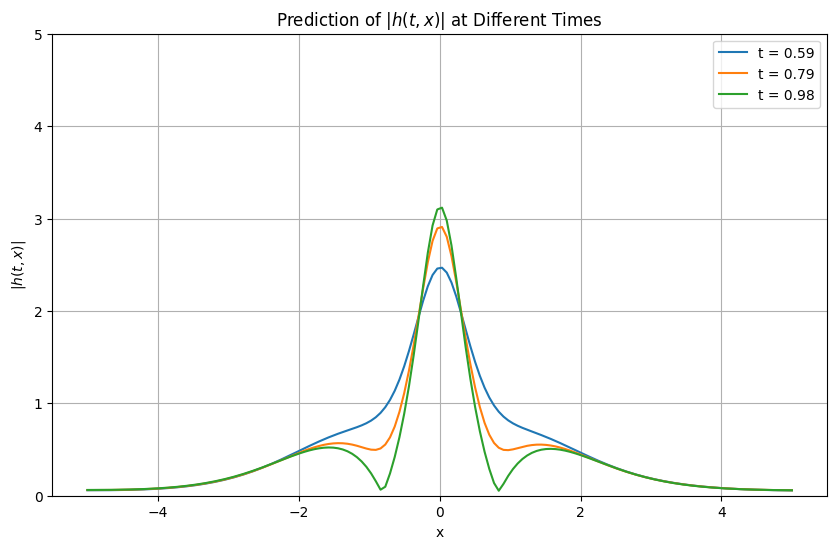

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to plot the results for specific times (Prediction)
def plot_prediction_at_times(net, x_values, t_values, device):
    net.eval()  # Put the network in evaluation mode
    plt.figure(figsize=(10, 6))

    for t in t_values:
        # Prepare x and t inputs
        t_fixed = np.full((x_values.shape[0], 1), t)
        pt_x = torch.from_numpy(x_values).float().to(device)
        pt_t = torch.from_numpy(t_fixed).float().to(device)

        # Predict |h(t, x)| using the trained network
        with torch.no_grad():
            h_pred = net(pt_x, pt_t)
            u_pred = h_pred[:, 0:1]  # Extract u
            v_pred = h_pred[:, 1:2]  # Extract v
            h_pred = torch.sqrt(u_pred**2 + v_pred**2)  # |h(t, x)| = sqrt(u^2 + v^2)
            h_pred = h_pred.cpu().numpy()  # Convert back to NumPy

        # Plot |h(t, x)| for this specific t
        plt.plot(x_values, h_pred, label=f"t = {t}")

    plt.title(r"Prediction of $|h(t, x)|$ at Different Times")
    plt.xlabel("x")
    plt.ylabel(r"$|h(t, x)|$")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 5)  # Set y-axis range to be between 0 and 5 (for |h(t, x)|)
    plt.show()

# Define the x-values and t-values for evaluation
x_values = np.linspace(-5, 5, 150).reshape(-1, 1)  # 150 points in x (range from -5 to 5)
t_values = [0.59, 0.79, 0.98]  # Specific time points for prediction

# Plot the prediction
plot_prediction_at_times(net, x_values, t_values, device)


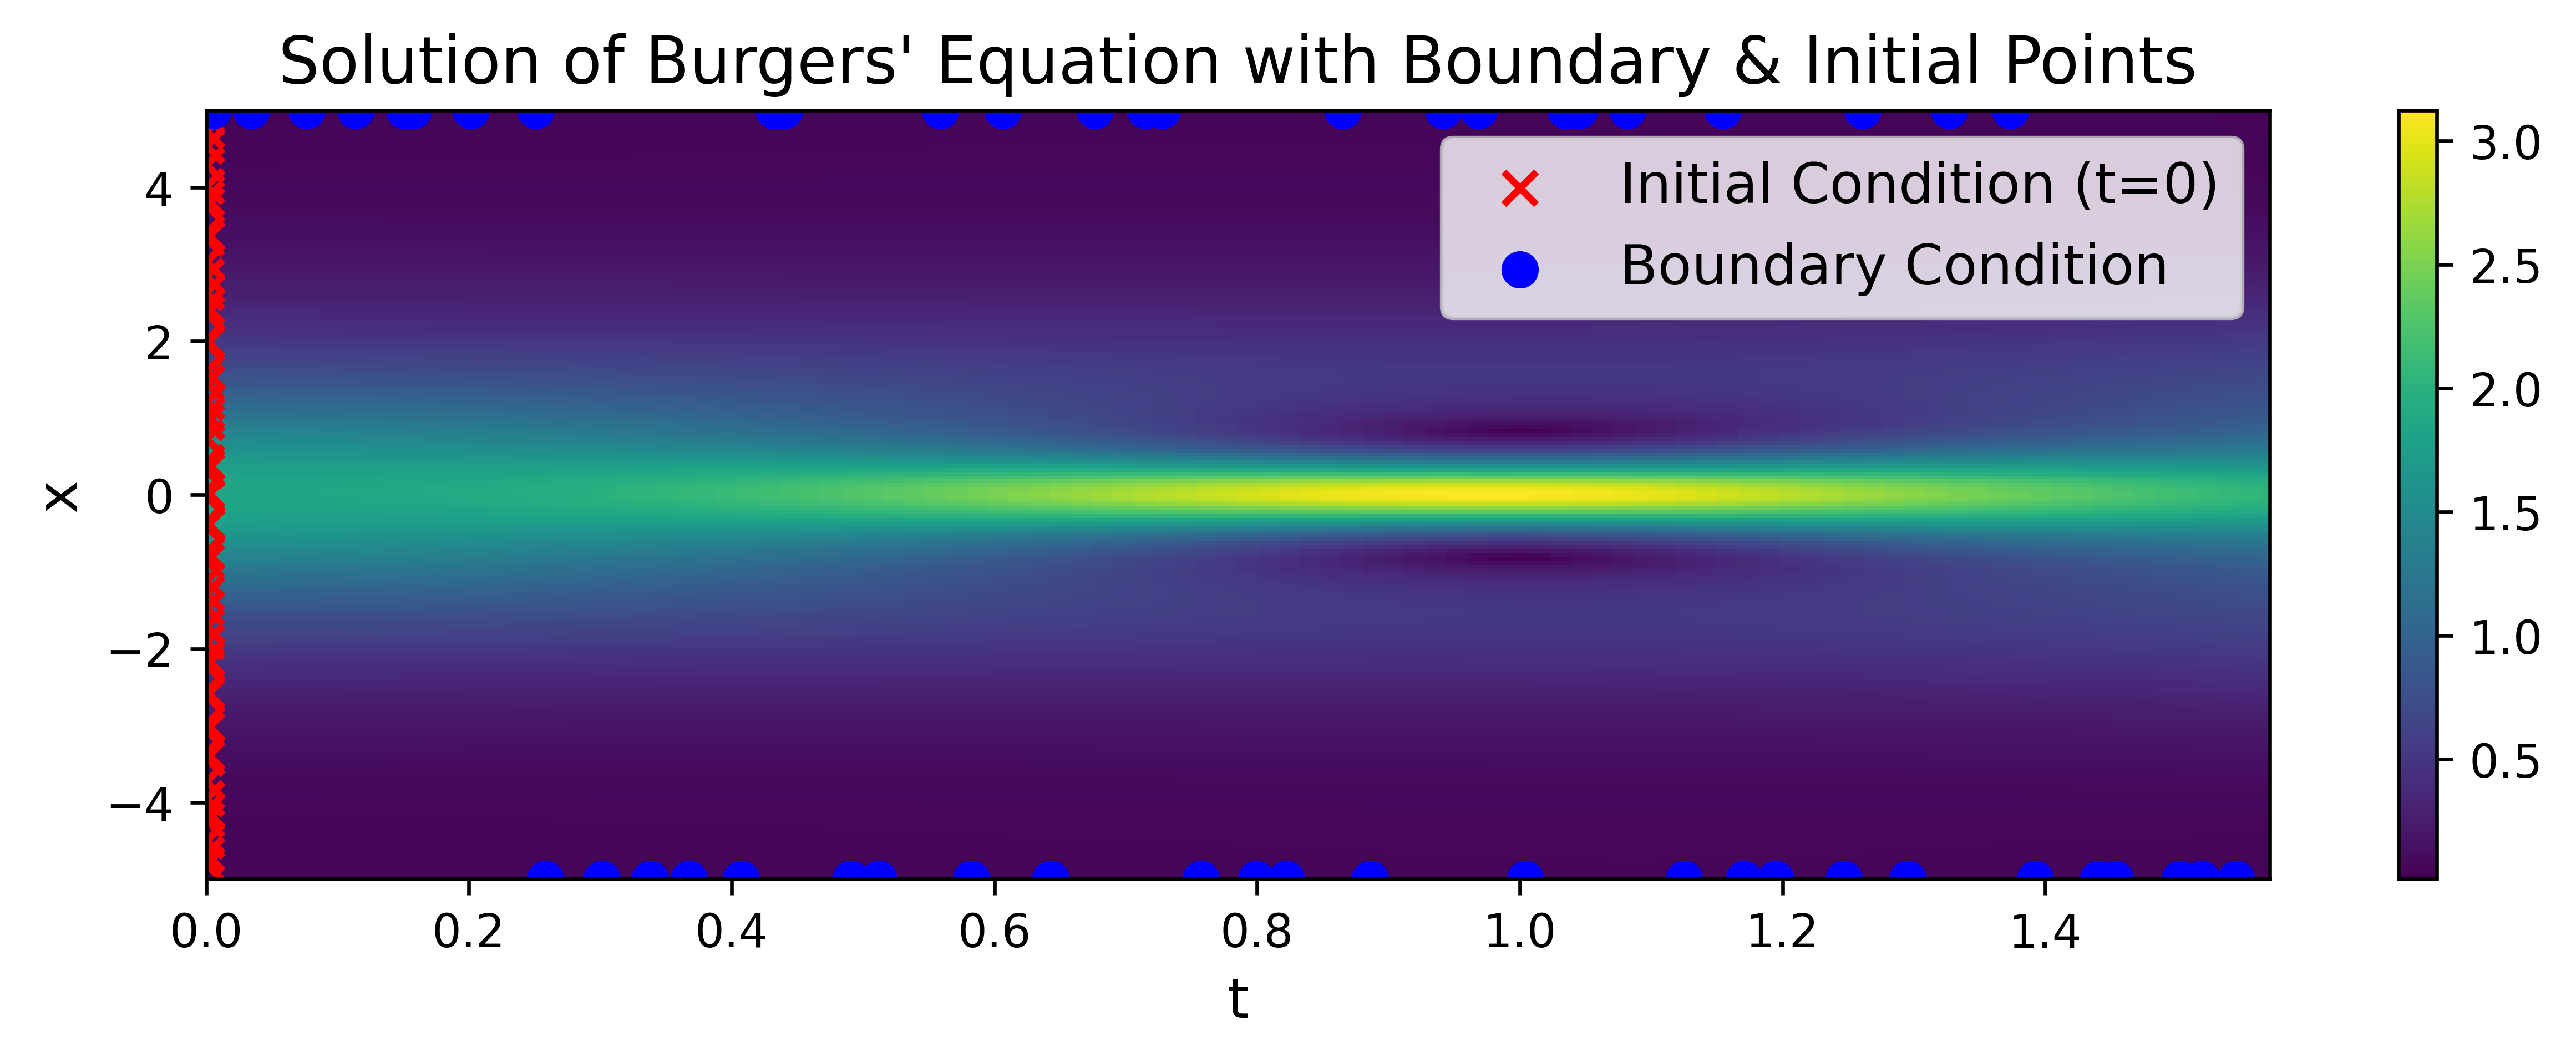

In [124]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to plot the solution on a 2D grid and overlay data points
def plot_solution_2d_with_points(net, x_values, t_values, device, t_d_o, x_d_o, t_d_b, x_d_b):
    net.eval()  # Set the model to evaluation mode
    
    n = len(t_values)
    m = len(x_values)
    X, T = np.meshgrid(x_values, t_values)  # Create meshgrid for x and t
    
    # Prepare x and t inputs (reshape to ensure proper dimensions)
    pt_x = torch.from_numpy(X.flatten()).float().to(device).unsqueeze(1)
    pt_t = torch.from_numpy(T.flatten()).float().to(device).unsqueeze(1)
    
    # Predict u(x, t) using the trained network
    with torch.no_grad():
        u_pred = net(pt_x, pt_t)
        
        # Reshape the predicted values to match the meshgrid shape
        u_pred = u_pred.cpu().numpy().reshape(n, m, 2)
        
        # Calculate |h(t, x)| = sqrt(u^2 + v^2)
        h_pred = np.sqrt(u_pred[:, :, 0]**2 + u_pred[:, :, 1]**2)

    # Plot the 2D solution with color mesh
    plt.figure(figsize=(10, 3), dpi=600)  # Further reduced height to 3 to make the figure more compact
    plt.pcolormesh(T, X, h_pred, cmap=cm.viridis, shading='auto')  # Plot the 2D color mesh
    plt.colorbar()  # Add a color bar
    plt.title("Solution of Burgers' Equation with Boundary & Initial Points", fontsize=14)
    plt.xlabel("t", fontsize=12)
    plt.ylabel("x", fontsize=12)
    plt.xlim([0, np.pi / 2])  # Limit t-axis to 0 to pi/2
    plt.ylim([-5, 5])  # Limit x-axis to -5 to 5
    
    # Overlay the boundary and initial condition points
    plt.scatter(t_d_o, x_d_o, marker="x", c="r", s=50, label="Initial Condition (t=0)")  # IC points
    plt.scatter(t_d_b, x_d_b, marker="o", c="b", s=50, label="Boundary Condition")  # BC points
    
    plt.legend(fontsize=12)  # Add a legend for data points
    
    plt.show()

# Define the x-values and t-values for evaluation
x_values = np.linspace(-5, 5, 200)  # 200 points in x (range from -5 to 5)
t_values = np.linspace(0, np.pi / 2, 100)  # 100 points in t (range from 0 to pi/2)

# Assuming you already have the data points t_d_o, x_d_o, t_d_b, x_d_b as per your problem
# Call the plot_solution_2d_with_points function
plot_solution_2d_with_points(net, x_values, t_values, device, t_d_o, x_d_o, t_d_b, x_d_b)
